# A simpler network

In the [other notebook](./follow-tf-tutorial.ipynb) I followed the tutorial almost exactly. The primary reason for doing that was to get a feel for the TensorFlow API. Now that I have that, I'm going to try to build a simpler network that I can understand better. Additionally, having covered one of the most important steps -- data preparation -- I can focus on the network itself.

---
The beginning of this notebook will be the same as the other one, but I'll try to make it more concise.

In [1]:
# I need to make a tf.data pipeline. I have a huggingface dataset, so I need to convert it somehow.
# Huggingface has tools built in to convert to tf.data, but I don't think they're exactly what I want.
# I think I might just try and breakdown the huggingface dataset to standard python objects to convert it all.

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # stop showing tensorflow logs...

from datasets import load_dataset
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf

dataset_name = "msaad02/formatted-ss-cleaned-brockport-qa"
dataset = load_dataset(dataset_name, split="train")

dataset = dataset.to_dict()['text']
dataset[0:5]

['Below is an inquiery related to SUNY Brockport - from academics, admissions, and faculty support to student life. Prioritize accuracy and brevity."\n\n### Instruction:\nWhat limitations are there for non-matriculated students if they choose to enroll at a later date?\n\n### Response:\nIf non-matriculated students choose to enroll at a later date, they are subject to all changes in the course catalog.',
 'Below is an inquiery related to SUNY Brockport - from academics, admissions, and faculty support to student life. Prioritize accuracy and brevity."\n\n### Instruction:\nWhere can I find more information about scholarships and financial aid?\n\n### Response:\nYou can find more information about scholarships and financial aid by visiting the college website or contacting the college\'s financial aid office.',
 'Below is an inquiery related to SUNY Brockport - from academics, admissions, and faculty support to student life. Prioritize accuracy and brevity."\n\n### Instruction:\nWhat res

In [2]:
# Check that GPU is detected
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Formatting

This dataset was built for the fine-tuning step. Perhaps I should change this such that the questions and answers are in separate columns, and then put it all together only in the notebook for fine-tuning. It should be simple enough to work with like this though, so for now this step is just going to split it into QA pairs.

In [3]:
def split_input_output(s):
    """
    Splits a string into a question and answer pair
    """
    output_split = s.split('\n\n### Response:\n')
    input_split = output_split[0].split('### Instruction:\n')[1]
    return input_split, output_split[1]

# Map above function over the list of questions, and create a list of questions and answers separately
context_raw, target_raw = [list(t) for t in zip(*[split_input_output(string) for string in dataset])]

# NOTE: Chosing to follow the naming conventions from the tutorial, for reference then:
# CONTEXT refers to QUESTIONS, and TARGET refers to ANSWERS

# "Raw" is used since currently the data is in string format, and needs to be standardized and vectorized

In [4]:
# Example
print(context_raw[-1])
print(target_raw[-1])

How can current students access their university email?
Current students can access their university email through the Webmail quicklink. It provides a secure platform for students to manage their university email accounts and communicate with faculty, staff, and peers.


# Creating a tf.data dataset

Now my data matches the format of the Spanish-to-English example in the tutorial, so I can use the same code to create a tf.data dataset.

In [5]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train_mask = np.random.uniform(size=(len(target_raw),)) < 0.8

train_context = np.array(context_raw)[is_train_mask]
train_target = np.array(target_raw)[is_train_mask]

val_context = np.array(context_raw)[~is_train_mask]
val_target = np.array(target_raw)[~is_train_mask]

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((train_context, train_target))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

val_raw = (
    tf.data.Dataset
    .from_tensor_slices((val_context, val_target))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

In [6]:
# Check to see it worked
for example_context_strings, example_target_strings in train_raw.take(1):
    print(example_context_strings[:5])
    print()
    print(example_target_strings[:5])
    break

tf.Tensor(
[b'What are the quicklinks available to access various resources or services?'
 b'Where can students connect with SUNY Brockport on social media?'
 b'How can Earth Sciences contribute to understanding climate change?'
 b"What courses from JCC can fulfill Brockport's local general education requirements?"
 b'What is the approach of the EAP?'], shape=(5,), dtype=string)

tf.Tensor(
[b'The quicklinks available are Webmail, Web Banner, Brightspace, Directory, Course Schedule, Accommodate, Student Bill Pay, EagleSUCCESS, myBROCKPORT, University Policies, Brockport Today, Events Calendar, Academic Calendar, Library, IT Service Desk, NetID Lookup & Password Change, Emergency Info, and Issue Reporting Center.'
 b'Students can connect with SUNY Brockport on Instagram, Facebook, Twitter, YouTube, and LinkedIn.'
 b"Earth Sciences can contribute to understanding climate change by studying past climate records, analyzing current climate patterns, and predicting future climate trends base

# Text Standardization

The text vectorization method from keras will take care of a lot of this, but this is an additional step with some specifics to Spanish, but also adds special tokens for the tokenizer.

In [7]:
def tf_lower_and_split_punct(text):
    """
    Text standardization function. Tries to make things uniform.
    """
    text = tf.strings.lower(text) # Lowercase everything
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '') # Keep space, a to z and punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ') # Add spaces around punctuation.
    text = tf.strings.strip(text) # Strip whitespace.

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ') # Add start and end token
    return text

MAX_VOCAB_SIZE = 5000

text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=MAX_VOCAB_SIZE,
    ragged=True
)

text_processor.adapt(train_raw.map(lambda context, target: context))
text_processor.adapt(train_raw.map(lambda context, target: target))

# Process The Dataset

*DESCRIPTION TAKEN DIRECTLY FROM THE TENSORFLOW TUTORIAL*

The process_text function below converts the Datasets of strings, into 0-padded tensors of token IDs. It also converts from a (context, target) pair to an ((context, target_in), target_out) pair for training with keras.Model.fit. Keras expects (inputs, labels) pairs, the inputs are the (context, target_in) and the labels are target_out. The difference between target_in and target_out is that they are shifted by one step relative to eachother, so that at each location the label is the next token.

In [8]:
def process_text(context, target):
    context = text_processor(context).to_tensor()
    target  = text_processor(target)
    targ_in = target[:,:-1].to_tensor()
    targ_out = target[:,1:].to_tensor()
    return (context, targ_in), targ_out

train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [9]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
    print(ex_context_tok[0, :15].numpy())
    print()
    print(ex_tar_in[0, :15].numpy())
    print(ex_tar_out[0, :15].numpy())

# Notice here that the target output is the same as the target input, but shifted one token to the right.

[  5  13 177 187 359  31 502  12   4 277  43  28   1   6   0]

[  5  25   2 359  18 190  31  17  38 236   4 277  43  28   3]
[ 25   2 359  18 190  31  17  38 236   4 277  43  28   3   6]


---

# Modeling

Now we have a dataset, we can start modeling. This first attempt will be to recreate the majority of what is in the other notebook, but with a simpler more readable imeplementation.

In [10]:
UNITS = 256
VOCAB_SIZE = text_processor.vocabulary_size()
# EMBEDDING_DIM = 64

# Encoder
encoder = tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=3)

# Decoder
decoder = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=3),
    tf.keras.layers.GRU(units=UNITS, return_sequences=True),
    tf.keras.layers.Dense(VOCAB_SIZE)
])

In [11]:
from tensorflow.python.keras.layers import Embedding, LSTM, AdditiveAttention, Concatenate, Dense
from tensorflow.python.keras import Input, Model

# This is GPT generated. I want to make a simpler one on my own before building it up to something like this. Also will save time if I start simpler and build up

# Encoder
encoder_inputs = Input(shape=(None,))
encoder_embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=UNITS)(encoder_inputs)
encoder_lstm, state_h, state_c = LSTM(units=UNITS, return_state=True)(encoder_embedding)
encoder_states = [state_h, state_c]

# Attention
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=UNITS)(decoder_inputs)
decoder_lstm, _, _ = LSTM(units=UNITS, return_sequences=True, return_state=True)(decoder_embedding, initial_state=encoder_states)
attention = AdditiveAttention()([decoder_lstm, encoder_lstm])
decoder_concat = Concatenate(axis=-1)([decoder_lstm, attention])

# Decoder
output_layer = Dense(VOCAB_SIZE, activation='softmax')
outputs = output_layer(decoder_concat)

# Model
model = Model([encoder_inputs, decoder_inputs], outputs)

In [12]:
### ACCURACY METRIC FUNCTIONS
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [13]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=masked_loss, 
    metrics=[masked_acc, masked_loss]
)

history = model.fit(
    train_ds.repeat(), 
    epochs=2, # 100
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=20)
    ]
)

Epoch 1/2


/home/msaad/miniconda3/envs/tf/lib/python3.9/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


100/100 [==============================] - 57s 544ms/step - loss: 5.9500 - masked_acc: 0.1031 - masked_loss: 5.9470 - val_loss: 5.3540 - val_masked_acc: 0.1332 - val_masked_loss: 5.3540
Epoch 2/2
100/100 [==============================] - 53s 529ms/step - loss: 4.9775 - masked_acc: 0.2082 - masked_loss: 4.9759 - val_loss: 4.6459 - val_masked_acc: 0.2472 - val_masked_loss: 4.6459


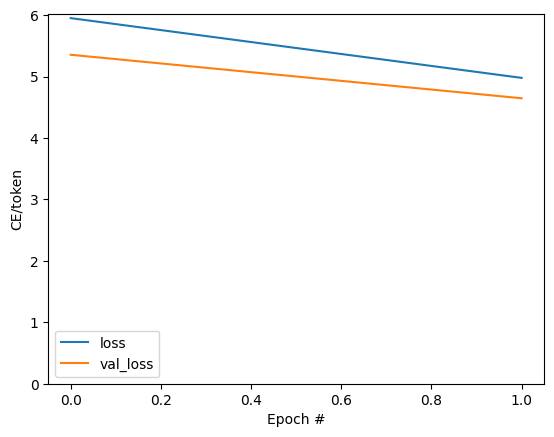

In [14]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

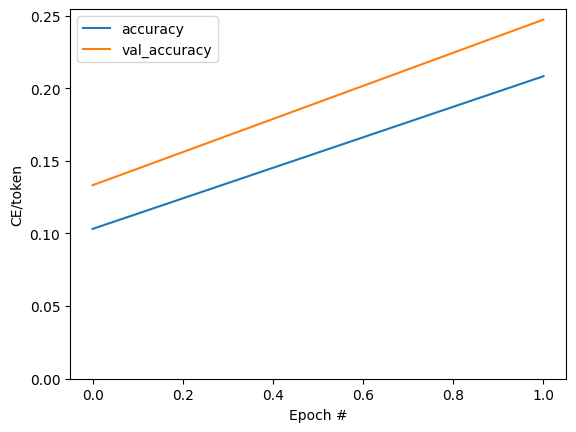

In [15]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

# Work in progress

Need to build a predict step that accepts text and runs it through the model.

In [ ]:
def convert_input(texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
        texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = text_processor(texts).to_tensor()
    return context

def predict(input_text):
    # Preprocess the input text
    input_tokens = tokenizer_input.texts_to_sequences([input_text])
    input_tokens_padded = tf.keras.preprocessing.sequence.pad_sequences(input_tokens, maxlen=max_length_input, padding='post')

    # Initialize the decoder input as a sequence with just the start token
    decoder_input = np.zeros((1, 1))
    decoder_input[0, 0] = target_tokenizer.word_index['<start>']  # Assuming <start> is the start token

    # Predict
    output_text = ''
    for i in range(max_length_target):
        predictions = model.predict([input_tokens_padded, decoder_input])
        predicted_id = np.argmax(predictions[0, -1, :])

        # Convert the predicted ID to a word
        predicted_word = target_tokenizer.index_word[predicted_id]

        # Stop if the end token is reached
        if predicted_word == '<end>':
            break

        # Append the predicted word to the output text
        output_text += predicted_word + ' '

        # Update the decoder input for the next prediction
        decoder_input[0, 0] = predicted_id

    return output_text.strip()


In [ ]:
convert_input("Hello world")